<a href="https://colab.research.google.com/github/s0han24/NA_RLPSO/blob/main/NA_RL_PSO_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.datasets import load_digits, load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
# Define objective function to minimize (Rastrigin function)
def rastrigin(x):
    A = 10
    return A * len(x) + sum([(xi ** 2 - A * np.cos(2 * np.pi * xi)) for xi in x])

In [ ]:
# Particle Swarm Optimization implementation (baseline)
class Particle:
    def __init__(self, dim, bounds, objective=rastrigin, random_sequence=None):
        # replace random with some sequence for experimentation
        if random_sequence is not None:
            self.position = random_sequence
        else:
            self.position = np.array([random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)])
        self.velocity = np.zeros(dim)
        self.best_position = np.copy(self.position)
        self.best_value = objective(self.position)

class PSO:
    def __init__(self, dim, bounds, num_particles=30, num_iter=100, objective=rastrigin, random_sequences=None):
        self.dim = dim
        self.bounds = bounds
        self.num_particles = num_particles
        self.num_iter = num_iter
        self.objective = objective
        if random_sequences is None:
            self.swarm = [Particle(dim, bounds, objective) for _ in range(num_particles)]
        else :
            self.swarm = [Particle(dim, bounds, objective, random_sequence) for random_sequence in random_sequences]
        self.global_best_position = np.copy(self.swarm[0].position)
        self.global_best_value = objective(self.global_best_position)
        self.history_X = []
        self.history_V = []
        self.history_results = []

    def optimize(self):
        w = 0.5
        c1, c2 = 1.5, 1.5
        X = [particle.position for particle in self.swarm]
        V = [particle.velocity for particle in self.swarm]
        self.history_X.append(X)
        self.history_V.append(V)
        self.history_results.append(self.global_best_value)
        for _ in range(self.num_iter):
            X = []
            V = []
            for particle in self.swarm:
                r1, r2 = random.random(), random.random()
                particle.velocity = (w * particle.velocity +
                                     c1 * r1 * (particle.best_position - particle.position) +
                                     c2 * r2 * (self.global_best_position - particle.position))
                particle.position = np.clip(particle.position + particle.velocity, self.bounds[:, 0], self.bounds[:, 1])
                value = self.objective(particle.position)
                X.append(particle.position)
                V.append(particle.velocity)
                if value < particle.best_value:
                    particle.best_position, particle.best_value = particle.position, value
                if value < self.global_best_value:
                    self.global_best_position, self.global_best_value = particle.position, value
            self.history_X.append(X)
            self.history_V.append(V)
            self.history_results.append(self.global_best_value)
        return self.global_best_position, self.global_best_value, self.history_X, self.history_V, self.history_results

In [ ]:
# Policy Network for the RL component
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=16):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.action_mean = nn.Linear(hidden_size, action_dim)
        # Learnable log_std parameter for the Gaussian distribution
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mean = self.action_mean(x)
        std = torch.exp(self.log_std)
        return mean, std

    def select_action(self, state):
        mean, std = self.forward(state)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()  # Sum log probabilities across dimensions
        # Clamp actions to a plausible range for c1 and c2 (e.g., [1.0, 2.0])
        action = torch.clamp(action, 1.0, 2.0)
        return action, log_prob

# RL-enhanced PSO using the policy network to select acceleration coefficients c1 and c2
class RLPSO(PSO):
    def __init__(self, dim, bounds, num_particles=30, num_iter=100, objective=rastrigin, lr=1e-2, random_sequences=None):
        super().__init__(dim, bounds, num_particles, num_iter, objective, random_sequences)
        # Define a simple state: [iteration_ratio, global_best_value]
        self.state_dim = 2
        self.action_dim = 2  # one for c1 and one for c2
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.objective = objective
        self.history_X = []
        self.history_V = []
        self.history_results = []

    def get_state(self, iteration):
        # Normalize iteration to [0, 1]
        iter_norm = iteration / self.num_iter
        # Use the current global best value (optionally, further normalization can be applied)
        state = np.array([iter_norm, self.global_best_value], dtype=np.float32)
        return torch.tensor(state)

    def optimize(self):
        w = 0.5

        X = [particle.position for particle in self.swarm]
        V = [particle.velocity for particle in self.swarm]
        self.history_X.append(X)
        self.history_V.append(V)
        self.history_results.append(self.global_best_value)

        for it in tqdm(range(1, self.num_iter + 1), desc="Training progress"):
            state = self.get_state(it)
            action, log_prob = self.policy_net.select_action(state)
            c1, c2 = action.detach().numpy()  # use the selected coefficients for this iteration
            X = []
            V = []
            # Store the old global best for reward computation
            old_global_best = self.global_best_value
            for particle in self.swarm:
                r1, r2 = random.random(), random.random()
                particle.velocity = (w * particle.velocity +
                                     c1 * r1 * (particle.best_position - particle.position) +
                                     c2 * r2 * (self.global_best_position - particle.position))
                particle.position = np.clip(particle.position + particle.velocity, self.bounds[:,0], self.bounds[:,1])
                value = self.objective(particle.position)
                X.append(particle.position)
                V.append(particle.velocity)
                if value < particle.best_value:
                    particle.best_position, particle.best_value = particle.position, value
                if value < self.global_best_value:
                    self.global_best_position, self.global_best_value = particle.position, value
            self.history_X.append(X)
            self.history_V.append(V)
            self.history_results.append(self.global_best_value)

            # Reward: improvement in global best value
            reward = old_global_best - self.global_best_value
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            # Update policy network using the REINFORCE rule: maximize reward
            loss = -log_prob * reward_tensor
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return self.global_best_position, self.global_best_value, self.history_X, self.history_V, self.history_results


In [ ]:
# Testing both the baseline PSO and the RL-enhanced PSO
dim = 2
bounds = np.array([[-2,2] for _ in range(dim)])
num_particles = 40
num_iter = 30

# generate num_particles number of random sequences of length dim each
random_sequences = [np.array([random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)]) for _ in range(num_particles)]


print("Running baseline PSO...")
pso_solver = PSO(dim, bounds, num_particles, num_iter, random_sequences=random_sequences)
best_position_pso, best_value_pso, X_list_pso, V_list_pso, pso_results = pso_solver.optimize()
print("\nBaseline PSO solution:")
print("Best position:", best_position_pso)
print("Best value:", best_value_pso)

print("\nRunning RL-enhanced PSO (RLPSO)...")
rl_pso_solver = RLPSO(dim, bounds, num_particles, num_iter, random_sequences=random_sequences)
best_position_rl, best_value_rl, X_list, V_list, rl_pso_results = rl_pso_solver.optimize()
print("\nRLPSO solution:")
print("Best position:", best_position_rl)
print("Best value:", best_value_rl)

Running baseline PSO...

Baseline PSO solution:
Best position: [ 9.94960111e-01 -8.58005025e-06]
Best value: 0.9949590721286015

Running RL-enhanced PSO (RLPSO)...


Training progress: 100%|██████████| 30/30 [00:00<00:00, 545.37it/s]


RLPSO solution:
Best position: [-3.31149194e-05  1.46091315e-05]
Best value: 2.5989852048269313e-07


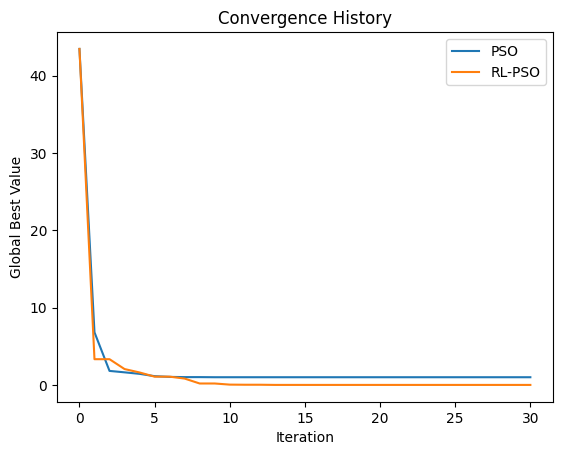

In [ ]:
# prompt: plot the history from the pso algorithms

import matplotlib.pyplot as plt

# Plot the history of the global best value for both PSO algorithms
plt.plot(pso_results, label='PSO')
plt.plot(rl_pso_results, label='RL-PSO')
plt.xlabel('Iteration')
plt.ylabel('Global Best Value')
plt.title('Convergence History')
plt.legend()
plt.show()


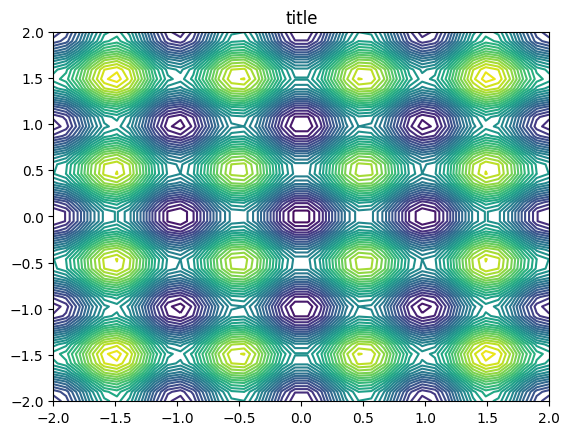

In [ ]:
import numpy as np


def demo_func(x):
    return rastrigin(x)


constraint_ueq = (
    lambda x: (x[0] - 1) ** 2 + (x[1] - 0) ** 2 - 0.5 ** 2
    ,
)

# max_iter = 50
# pso = PSO(func=demo_func, n_dim=2, pop=40, max_iter=max_iter, lb=[-2, -2], ub=[2, 2]
#           , constraint_ueq=constraint_ueq)
# pso.record_mode = True
# pso.run()
# print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

# %% Now Plot the animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# record_value = pso.record_value
# X_list, V_list = record_value
max_iter = num_iter

fig, ax = plt.subplots(1, 1)
ax.set_title('title', loc='center')
line = ax.plot([], [], 'b.')

X_grid, Y_grid = np.meshgrid(np.linspace(-2.0, 2.0, 40), np.linspace(-2.0, 2.0, 40))
Z_grid = demo_func((X_grid, Y_grid))
ax.contour(X_grid, Y_grid, Z_grid, 30)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

t = np.linspace(0, 2 * np.pi, 40)

plt.ion()
p = plt.show()


def update_scatter(frame):
    i, j = frame // 10, frame % 10
    ax.set_title('iter = ' + str(i))
    # X_tmp = X_list[i] + V_list[i] * j / 10.0  # Original line causing the error

    # Reshape X_list[i] and V_list[i] to be 2D arrays
    X_tmp = np.array(X_list[i]).reshape(-1, 2) + np.array(V_list[i]).reshape(-1,2) * j / 10.0

    # Now X_tmp is a 2D array and can be indexed with [:, 0] and [:, 1]
    plt.setp(line, 'xdata', X_tmp[:, 0], 'ydata', X_tmp[:, 1])
    return line


ani = FuncAnimation(fig, update_scatter, blit=True, interval=25, frames=max_iter * 10)
plt.show()

ani.save('pso.gif', writer='pillow')

In [ ]:
!pip install scikit-opt

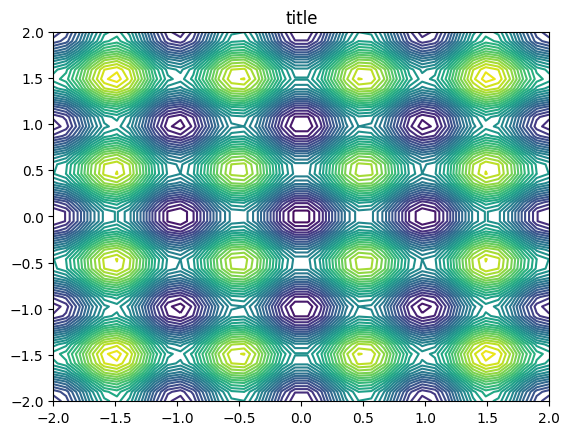

In [ ]:
import numpy as np


# %% Now Plot the animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1)
ax.set_title('title', loc='center')
line = ax.plot([], [], 'b.')

X_grid, Y_grid = np.meshgrid(np.linspace(-2.0, 2.0, 40), np.linspace(-2.0, 2.0, 40))
Z_grid = demo_func((X_grid, Y_grid))
ax.contour(X_grid, Y_grid, Z_grid, 30)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

t = np.linspace(0, 2 * np.pi, 40)

plt.ion()
p = plt.show()


def update_scatter(frame):
    i, j = frame // 10, frame % 10
    ax.set_title('iter = ' + str(i))
    # X_tmp = X_list[i] + V_list[i] * j / 10.0  # Original line causing the error

    # Reshape X_list[i] and V_list[i] to be 2D arrays
    X_tmp = np.array(X_list_pso[i]).reshape(-1, 2) + np.array(V_list_pso[i]).reshape(-1,2) * j / 10.0

    # Now X_tmp is a 2D array and can be indexed with [:, 0] and [:, 1]
    plt.setp(line, 'xdata', X_tmp[:, 0], 'ydata', X_tmp[:, 1])
    return line


ani = FuncAnimation(fig, update_scatter, blit=True, interval=25, frames=max_iter * 10)
plt.show()

ani.save('pso_norl.gif', writer='pillow')

## Training some simple models to test hyperparameter tuning capabilities

#### Model 1: Simple MLP for MNIST

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, hidden_size=128, dropout_rate=0.2):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_mnist(
    hidden_size=128,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    epochs=5,
    weight_decay=0.0,
    momentum=0.9,
    optimizer_type='adam'
):
    """
    Train a simple MLP on MNIST dataset

    Parameters:
    - hidden_size: number of neurons in the hidden layer
    - dropout_rate: dropout probability
    - learning_rate: learning rate for the optimizer
    - batch_size: size of mini-batches
    - epochs: number of training epochs
    - weight_decay: L2 regularization parameter
    - momentum: momentum parameter (for SGD)
    - optimizer_type: 'adam' or 'sgd'

    Returns:
    - trained model
    - dictionary with training history
    """
    # Data loading
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleMLP(hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)

    if optimizer_type.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                             momentum=momentum, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    # Training loop
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)

        # Evaluation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = correct / total

        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    return model, history

#### Model 2: CNN for CIFAR-10

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, filters1=32, filters2=64, dropout_rate=0.25):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, filters1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(filters1)
        self.conv2 = nn.Conv2d(filters1, filters2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters2)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(filters2 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_cifar10(
    filters1=32,
    filters2=64,
    dropout_rate=0.25,
    learning_rate=0.001,
    batch_size=128,
    epochs=10,
    weight_decay=0.0001,
    optimizer_type='adam'
):
    """
    Train a simple CNN on CIFAR-10 dataset

    Parameters:
    - filters1: number of filters in first conv layer
    - filters2: number of filters in second conv layer
    - dropout_rate: dropout probability
    - learning_rate: learning rate for the optimizer
    - batch_size: size of mini-batches
    - epochs: number of training epochs
    - weight_decay: L2 regularization parameter
    - optimizer_type: 'adam' or 'sgd'

    Returns:
    - trained model
    - dictionary with training history
    """
    # Data loading
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN(filters1=filters1, filters2=filters2, dropout_rate=dropout_rate).to(device)

    if optimizer_type.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                             momentum=0.9, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    # Training loop
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)

        # Evaluation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = correct / total

        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        # Update learning rate
        scheduler.step(test_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    return model, history

## Baseline methods for hyperparameter tuning

In [ ]:
def random_search(model_func, param_grid, n_trials=10):
    """
    Perform random search for hyperparameter tuning

    Parameters:
    - model_func: function that trains the model with hyperparameters
    - param_grid: dictionary with hyperparameter names as keys and lists of possible values
    - n_trials: number of random combinations to try

    Returns:
    - best_params: dictionary with best hyperparameters
    - best_score: best validation score
    - results: list of (params, score) tuples for all trials
    """
    results = []
    best_score = float('-inf')
    best_params = None

    for _ in tqdm(range(n_trials)):
        # Sample random hyperparameters
        params = {k: random.choice(v) if isinstance(v, list) else v for k, v in param_grid.items()}

        # Train model with sampled hyperparameters
        _, history = model_func(**params)

        # Use the best test accuracy as the score
        score = max(history['test_acc'])

        results.append((params, score))

        # Update best parameters if needed
        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score, results

In [ ]:
def grid_search(model_func, param_grid):
    """
    Perform grid search for hyperparameter tuning

    Parameters:
    - model_func: function that trains the model with hyperparameters
    - param_grid: dictionary with hyperparameter names as keys and lists of possible values

    Returns:
    - best_params: dictionary with best hyperparameters
    - best_score: best validation score
    - results: list of (params, score) tuples for all trials
    """
    # Generate all combinations of parameters
    keys = param_grid.keys()
    values = [param_grid[key] for key in keys]
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    results = []
    best_score = float('-inf')
    best_params = None

    for params in tqdm(param_combinations):
        # Train model with parameters
        _, history = model_func(**params)

        # Use the best test accuracy as the score
        score = max(history['test_acc'])

        results.append((params, score))

        # Update best parameters if needed
        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score, results

In [ ]:
def PSO(model_func, param_grid, num_particles=30, num_iter=10, w=0.7, c1=2, c2=2):
    # TODO: implement this
    return


In [ ]:
def RL_PSO(model_func, param_grid, num_particles=30, num_iter=10):
    # TODO: implement this
    return

In [ ]:
def bayesian_optimization_example():
    """
    Example of how to use Bayesian Optimization for hyperparameter tuning

    This is just a skeleton, actual implementation would require a library like
    scikit-optimize or BoTorch
    """
    # Install with: pip install scikit-optimize
    try:
        from skopt import gp_minimize
        from skopt.space import Real, Integer, Categorical
    except ImportError:
        print("This example requires scikit-optimize. Install it with 'pip install scikit-optimize'")
        return

    # Define the search space
    space = [
        Integer(32, 256, name='hidden_size'),
        Real(0.0, 0.5, name='dropout_rate'),
        Real(0.0001, 0.1, 'log-uniform', name='learning_rate'),
        Categorical(['adam', 'sgd'], name='optimizer_type'),
    ]

    # Define the objective function (minimize negative accuracy)
    def objective(params):
        hidden_size, dropout_rate, learning_rate, optimizer_type = params

        # Train the model
        _, history = train_mnist(
            hidden_size=int(hidden_size),
            dropout_rate=dropout_rate,
            learning_rate=learning_rate,
            optimizer_type=optimizer_type,
            epochs=5  # Keep this low for faster iterations
        )

        # Return negative test accuracy for minimization
        return -max(history['test_acc'])

    # Run Bayesian optimization
    result = gp_minimize(
        objective,
        space,
        n_calls=10,
        random_state=42,
        verbose=True
    )

    # Extract the best parameters
    best_params = {
        'hidden_size': int(result.x[0]),
        'dropout_rate': result.x[1],
        'learning_rate': result.x[2],
        'optimizer_type': result.x[3]
    }

    best_score = -result.fun

    print(f"Best accuracy: {best_score:.4f}")
    print(f"Best parameters: {best_params}")

    return best_params, best_score

In [ ]:
param_grid_mnist = {
    'hidden_size': [64, 128, 256],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64, 128],
    'epochs': 3,  # Fixed for faster execution
    'optimizer_type': ['adam', 'sgd']
}

In [ ]:
print("\nExample 1: MNIST")
print("\nRandom Search")
best_params, best_score, results = random_search(train_mnist, param_grid_mnist, n_trials=5)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

In [ ]:
print("\n Grid Search")
best_params, best_score, results = grid_search(train_mnist, param_grid_mnist)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

In [1]:
# TODO: implement bayesian optim method


Bayesian Optimization


NameError: name 'bayesian_optimization_example' is not defined

In [ ]:
print("\n PSO")
best_params, best_score, results = PSO(train_mnist, param_grid_mnist)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

In [ ]:
print("\n RL PSO")
best_params, best_score, results = RL_PSO(train_mnist, param_grid_mnist)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}"

In [ ]:
param_grid_cifar10 = {
    'filters1': [32, 64, 128],
    'filters2': [64, 128, 256],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64, 128],
    'epochs': 3,  # Fixed for faster execution
    'optimizer_type': ['adam', 'sgd']
}

In [ ]:
print("\nExample 2: CIFAR-10")
print("\nRandom Search")
best_params, best_score, results = random_search(train_cifar10, param_grid_cifar10, n_trials=5)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

In [ ]:
print("\n Grid Search")
best_params, best_score, results = grid_search(train_cifar10, param_grid_cifar10)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

In [ ]:
print("\n PSO")
best_params, best_score, results = PSO(train_cifar10, param_grid_cifar10)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

In [ ]:
print("\n RL PSO")
best_params, best_score, results = RL_PSO(train_cifar10, param_grid_cifar10)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")